In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import re
import warnings
import os
from textblob import TextBlob
import talib
from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
DATA_DIR = "./data"
NEWS_PATH = os.path.join(DATA_DIR, "raw_analyst_ratings.csv")
TICKERS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
INITIAL_CAPITAL = 10000

In [3]:
print("=" * 80)
print("📥 LOADING LOCAL DATA")
print("=" * 80)

📥 LOADING LOCAL DATA


In [4]:
import os
df_news = None
if os.path.exists(NEWS_PATH):
    df = pd.read_csv(NEWS_PATH)
    print(f"✅ News loaded: {len(df)} records")

    # Handle date
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].dt.tz is None:
        df['date'] = df['date'].dt.tz_localize('UTC', ambiguous='infer')
    else:
        df['date'] = df['date'].dt.tz_convert('UTC')
    df = df.dropna(subset=['date'])
    df['date_only'] = df['date'].dt.date
    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")

    # Store
    df_news = df
else:
    print("⚠️ No news file found at:", NEWS_PATH)
    exit()

✅ News loaded: 1407328 records
   Date range: 2011-04-28 01:01:48+00:00 to 2020-06-11 21:12:35+00:00


In [7]:
# ==============================================================================
# 🔍 EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
print("\n" + "=" * 80)
print("📊 EXPLORATORY DATA ANALYSIS (NEWS)")
print("=" * 80)

# ------------------------------------------------------------------------------
# 1. Descriptive Statistics
# ------------------------------------------------------------------------------
print("\n1️⃣ Descriptive Statistics")

# Headline length
df_news['headline'] = df_news['headline'].fillna('')
df_news['headline_len'] = df_news['headline'].str.len()
avg_len = df_news['headline_len'].mean()
print(f"   • Avg headline length: {avg_len:.1f} characters")
print(f"   • Min: {df_news['headline_len'].min()}, Max: {df_news['headline_len'].max()}")

# Publisher stats
if 'publisher' in df_news.columns:
    pub_counts = df_news['publisher'].value_counts()
    print(f"   • Total unique publishers: {pub_counts.shape[0]}")
    print(f"   • Top publisher: {pub_counts.index[0]} ({pub_counts.iloc[0]} articles)")
else:
    print("   ⚠️ No 'publisher' column found.")

# Date trends
daily_counts = df_news.groupby('date_only').size()
print(f"   • Avg articles per day: {daily_counts.mean():.1f}")
print(f"   • Max articles in a day: {daily_counts.max()} on {daily_counts.idxmax()}")


📊 EXPLORATORY DATA ANALYSIS (NEWS)

1️⃣ Descriptive Statistics
   • Avg headline length: 80.0 characters
   • Min: 12, Max: 512
   • Total unique publishers: 225
   • Top publisher: Benzinga Newsdesk (14750 articles)
   • Avg articles per day: 22.4
   • Max articles in a day: 973 on 2020-03-12



2️⃣ Publisher Analysis
   • Top contributing domains:
        Benzinga Newsdesk: 14750
        Lisa Levin: 12408
        ETF Professor: 4362
        Paul Quintaro: 4212
        Benzinga Newsdesk: 3177


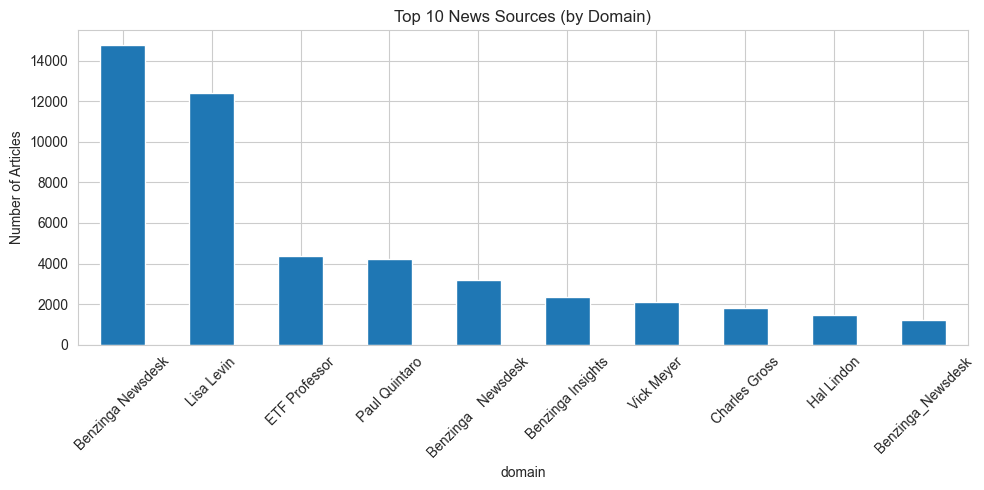

In [8]:
# ------------------------------------------------------------------------------
# 2. Publisher Analysis (with domain extraction if emails)
# ------------------------------------------------------------------------------
print("\n2️⃣ Publisher Analysis")

if 'publisher' in df_news.columns:
    # Extract domain if email-like
    df_news['publisher_clean'] = df_news['publisher'].astype(str)
    if df_news['publisher_clean'].str.contains('@').any():
        df_news['domain'] = df_news['publisher_clean'].str.split('@').str[-1]
        domain_counts = df_news['domain'].value_counts()
        print(f"   • Top contributing domains:")
        for dom, cnt in domain_counts.head(5).items():
            print(f"        {dom}: {cnt}")
    else:
        df_news['domain'] = df_news['publisher_clean']
        domain_counts = df_news['domain'].value_counts()

    # Plot top publishers/domains
    plt.figure(figsize=(10, 5))
    domain_counts.head(10).plot(kind='bar', title="Top 10 News Sources (by Domain)")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("   ⚠️ Skipped: 'publisher' column missing.")


3️⃣ Time Series Analysis


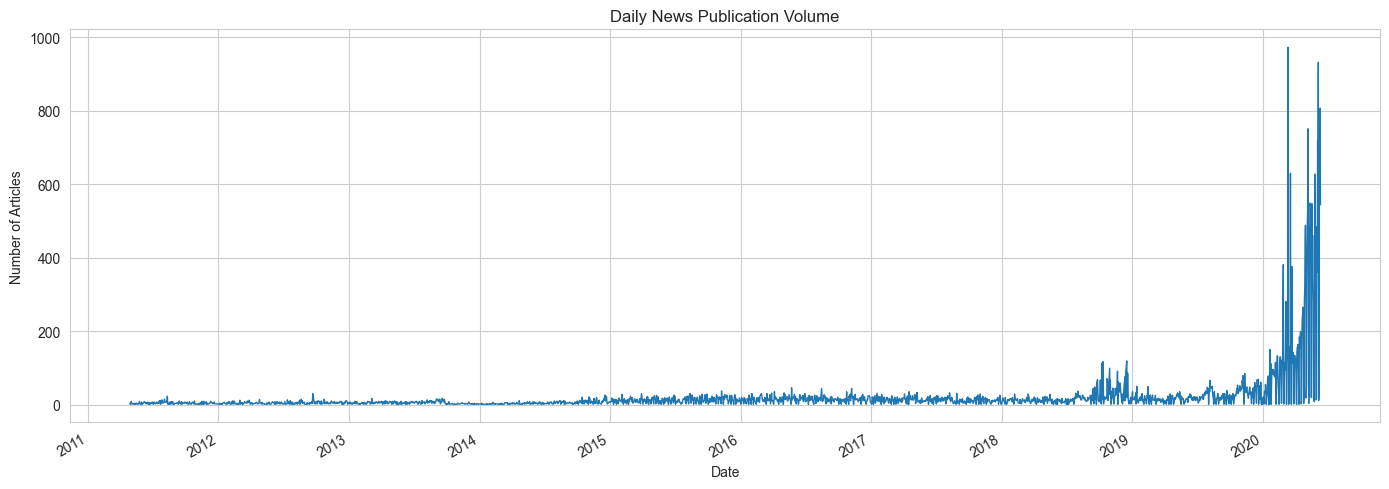

   • Articles by day of week:
        Monday: 10297
        Tuesday: 11037
        Wednesday: 11873
        Thursday: 12712
        Friday: 9407
        Saturday: 273
        Sunday: 388


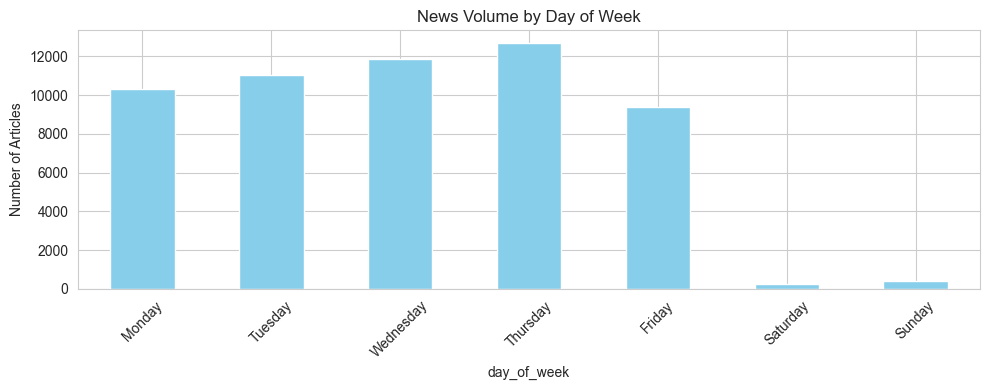


   • Top 5 highest-volume days (possible market events):
        2020-03-12: 973 articles
        2020-06-05: 932 articles
        2020-06-10: 807 articles
        2020-06-09: 803 articles
        2020-06-08: 765 articles


In [9]:
# ------------------------------------------------------------------------------
# 3. Time Series Analysis of News Volume
# ------------------------------------------------------------------------------
print("\n3️⃣ Time Series Analysis")

df_news['date_dt'] = pd.to_datetime(df_news['date_only'])
daily_volume = df_news.groupby('date_dt').size()

# Plot daily news volume
plt.figure(figsize=(14, 5))
daily_volume.plot(linewidth=1)
plt.title("Daily News Publication Volume")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly pattern
df_news['day_of_week'] = df_news['date_dt'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df_news['day_of_week'].value_counts().reindex(dow_order, fill_value=0)
print("   • Articles by day of week:")
for day, cnt in dow_counts.items():
    print(f"        {day}: {cnt}")

plt.figure(figsize=(10, 4))
dow_counts.plot(kind='bar', color='skyblue')
plt.title("News Volume by Day of Week")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify top 5 spike days (potential market events)
spike_days = daily_volume.nlargest(5)
print("\n   • Top 5 highest-volume days (possible market events):")
for date, count in spike_days.items():
    print(f"        {date.date()}: {count} articles")

In [10]:
# ------------------------------------------------------------------------------
# 4. Text & Topic Analysis
# ------------------------------------------------------------------------------
print("\n4️⃣ Text & Topic Analysis")

# Custom keyword function (as before)
def extract_keywords(headlines, n=10):
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of',
                  'with', 'by', 'from', 'as', 'is', 'was', 'are', 'be', 'this', 'that', 'it'}
    words = []
    for h in headlines:
        tokens = re.findall(r'\b[a-z]{3,}\b', str(h).lower())
        words.extend([w for w in tokens if w not in stop_words])
    return Counter(words).most_common(n)

top_words = extract_keywords(df_news['headline'], n=15)
print("   • Top keywords:")
print(", ".join([f"{w}({c})" for w, c in top_words]))

# Bigrams for phrases like "price target", "fda approval"
print("\n   • Top bigrams (2-word phrases):")
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20, min_df=2)
try:
    X = vectorizer.fit_transform(df_news['headline'])
    bigram_freq = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
    top_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]
    for phrase, freq in top_bigrams:
        print(f"        '{phrase}': {int(freq)}")
except ValueError:
    print("        Not enough valid bigrams.")

# Custom event phrase search
event_phrases = ['price target', 'fda approval', 'clinical trial', 'acquisition',
                 'merger', 'lawsuit', 'earnings', 'dividend', 'upgrade', 'downgrade']
print("\n   • Custom event phrase counts:")
for phrase in event_phrases:
    count = df_news['headline'].str.contains(phrase, case=False, na=False).sum()
    if count > 0:
        print(f"        '{phrase}': {count}")

# Sentiment by time/publisher (bonus)
df_news['sentiment'] = df_news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
print(f"\n   • Overall sentiment: mean={df_news['sentiment'].mean():.3f}, std={df_news['sentiment'].std():.3f}")

# Optional: Sentiment by top domain
if 'domain' in df_news.columns:
    top_domains = domain_counts.head(5).index
    sentiment_by_domain = df_news[df_news['domain'].isin(top_domains)].groupby('domain')['sentiment'].mean()
    print("\n   • Avg sentiment by top domain:")
    for dom, sent in sentiment_by_domain.items():
        print(f"        {dom}: {sent:.3f}")



4️⃣ Text & Topic Analysis
   • Top keywords:
stocks(12794), week(9029), shares(8393), trading(6575), hit(5902), eps(5531), market(5482), price(5046), companies(4778), target(4676), several(4650), sales(4429), higher(4271), estimate(3818), lows(3741)

   • Top bigrams (2-word phrases):
        '52 week': 8251
        'stocks hit': 5847
        'hit 52': 5846
        'price target': 4585
        'companies trading': 4082
        'week lows': 3687
        'trading higher': 3517
        'stocks moving': 2841
        'week highs': 2561
        'trading lower': 2152

   • Custom event phrase counts:
        'price target': 4586
        'fda approval': 27
        'clinical trial': 47
        'acquisition': 535
        'merger': 597
        'lawsuit': 30
        'earnings': 2277
        'dividend': 985
        'upgrade': 1495
        'downgrade': 2173

   • Overall sentiment: mean=0.038, std=0.156

   • Avg sentiment by top domain:
        Benzinga Newsdesk: 0.037
        Benzinga Newsdesk: 0

In [12]:
# ==============================================================================
# 📈 LOAD STOCK DATA
# ==============================================================================
print("\n" + "=" * 80)
print("📈 LOADING STOCK DATA")
print("=" * 80)
stock_data = {}
for ticker in TICKERS:
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        required = {'Open', 'High', 'Low', 'Close', 'Volume', 'Date'}
        if not required.issubset(df.columns):
            print(f"⚠️ {ticker}: Missing required columns. Skipping.")
            continue
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        if len(df) < 50:
            print(f"⚠️ {ticker}: Insufficient data after cleaning. Skipping.")
            continue
        stock_data[ticker] = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        print(f"✅ {ticker}: {len(df)} clean rows")
    else:
        print(f"⚠️ {ticker}.csv not found.")


📈 LOADING STOCK DATA
✅ AAPL: 7548 clean rows
✅ AMZN: 7548 clean rows
✅ GOOG: 7548 clean rows
✅ META: 5846 clean rows
✅ MSFT: 7548 clean rows
✅ NVDA: 7548 clean rows


In [13]:
def compute_metrics_manual(strat_returns, bh_returns=None, annualization_factor=252):
    """
    Compute key financial metrics manually (no PyNance needed).
    Assumes daily returns as decimal (e.g., 0.01 = 1%).
    """
    if strat_returns.empty:
        return {}

    returns = strat_returns.dropna()
    if len(returns) < 2:
        return {}

    # Annualized return
    total_return = (1 + returns).prod()
    ann_return = total_return ** (annualization_factor / len(returns)) - 1

    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(annualization_factor)

    # Sharpe Ratio (assume risk-free rate = 0)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan

    # Max Drawdown
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    metrics = {
        'Ann. Return %': round(ann_return * 100, 2),
        'Ann. Volatility %': round(ann_vol * 100, 2),
        'Sharpe Ratio': round(sharpe, 2) if not np.isnan(sharpe) else None,
        'Max Drawdown %': round(max_drawdown * 100, 2),
    }

    # Alpha/Beta vs benchmark (if provided)
    if bh_returns is not None:
        bh = bh_returns.reindex(returns.index).dropna()
        common_idx = returns.index.intersection(bh.index)
        if len(common_idx) >= 10:
            r = returns.loc[common_idx]
            b = bh.loc[common_idx]
            # Beta = Cov(r,b) / Var(b)
            beta = np.cov(r, b)[0, 1] / np.var(b)
            # Alpha = mean(r) - beta * mean(b)  → annualized
            alpha_daily = r.mean() - beta * b.mean()
            alpha_ann = alpha_daily * annualization_factor
            metrics['Alpha'] = round(alpha_ann, 4)
            metrics['Beta'] = round(beta, 4)
        else:
            metrics['Alpha'] = None
            metrics['Beta'] = None

    return metrics

In [14]:
# =============================================================================
# TA-LIB INDICATORS
# =============================================================================
print("\n" + "=" * 80)
print("🔧 COMPUTING TECHNICAL INDICATORS")
print("=" * 80)

def calc_indicators(df):
    df = df.copy()
    c = df['Close'].astype(float).values
    h = df['High'].astype(float).values
    l = df['Low'].astype(float).values
    df['SMA_20'] = talib.SMA(c, 20)
    df['SMA_50'] = talib.SMA(c, 50)
    df['EMA_12'] = talib.EMA(c, 12)
    df['EMA_26'] = talib.EMA(c, 26)
    df['RSI'] = talib.RSI(c, 14)
    macd, sig, hist = talib.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_Signal'] = sig
    df['MACD_Hist'] = hist
    upper, middle, lower = talib.BBANDS(c, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_Upper'] = upper
    df['BB_Middle'] = middle
    df['BB_Lower'] = lower
    df['BB_Width'] = (upper - lower) / middle * 100
    df['ATR'] = talib.ATR(h, l, c, 14)
    df['ADX'] = talib.ADX(h, l, c, 14)
    return df

for t in TICKERS:
    if t in stock_data:
        print(f"   → {t}")
        stock_data[t] = calc_indicators(stock_data[t])


🔧 COMPUTING TECHNICAL INDICATORS
   → AAPL
   → AMZN
   → GOOG
   → META
   → MSFT
   → NVDA


In [15]:
# =============================================================================
# SIGNAL GENERATION
# =============================================================================
def gen_signals(df):
    df = df.copy()
    df['RSI_Sig'] = 0
    df.loc[df['RSI'] < 30, 'RSI_Sig'] = 1
    df.loc[df['RSI'] > 70, 'RSI_Sig'] = -1
    macd_above = df['MACD'] > df['MACD_Signal']
    df['MACD_Cross'] = 0
    df.loc[macd_above & ~macd_above.shift(1).fillna(False), 'MACD_Cross'] = 1
    df.loc[~macd_above & macd_above.shift(1).fillna(False), 'MACD_Cross'] = -1
    ma_bull = df['SMA_20'] > df['SMA_50']
    df['MA_Cross'] = 0
    df.loc[ma_bull & ~ma_bull.shift(1).fillna(False), 'MA_Cross'] = 1
    df.loc[~ma_bull & ma_bull.shift(1).fillna(False), 'MA_Cross'] = -1
    total = df[['RSI_Sig', 'MACD_Cross', 'MA_Cross']].sum(axis=1)
    df['Signal'] = total.apply(lambda x: 1 if x >= 2 else -1 if x <= -2 else 0)
    return df

for t in TICKERS:
    if t in stock_data:
        stock_data[t] = gen_signals(stock_data[t])

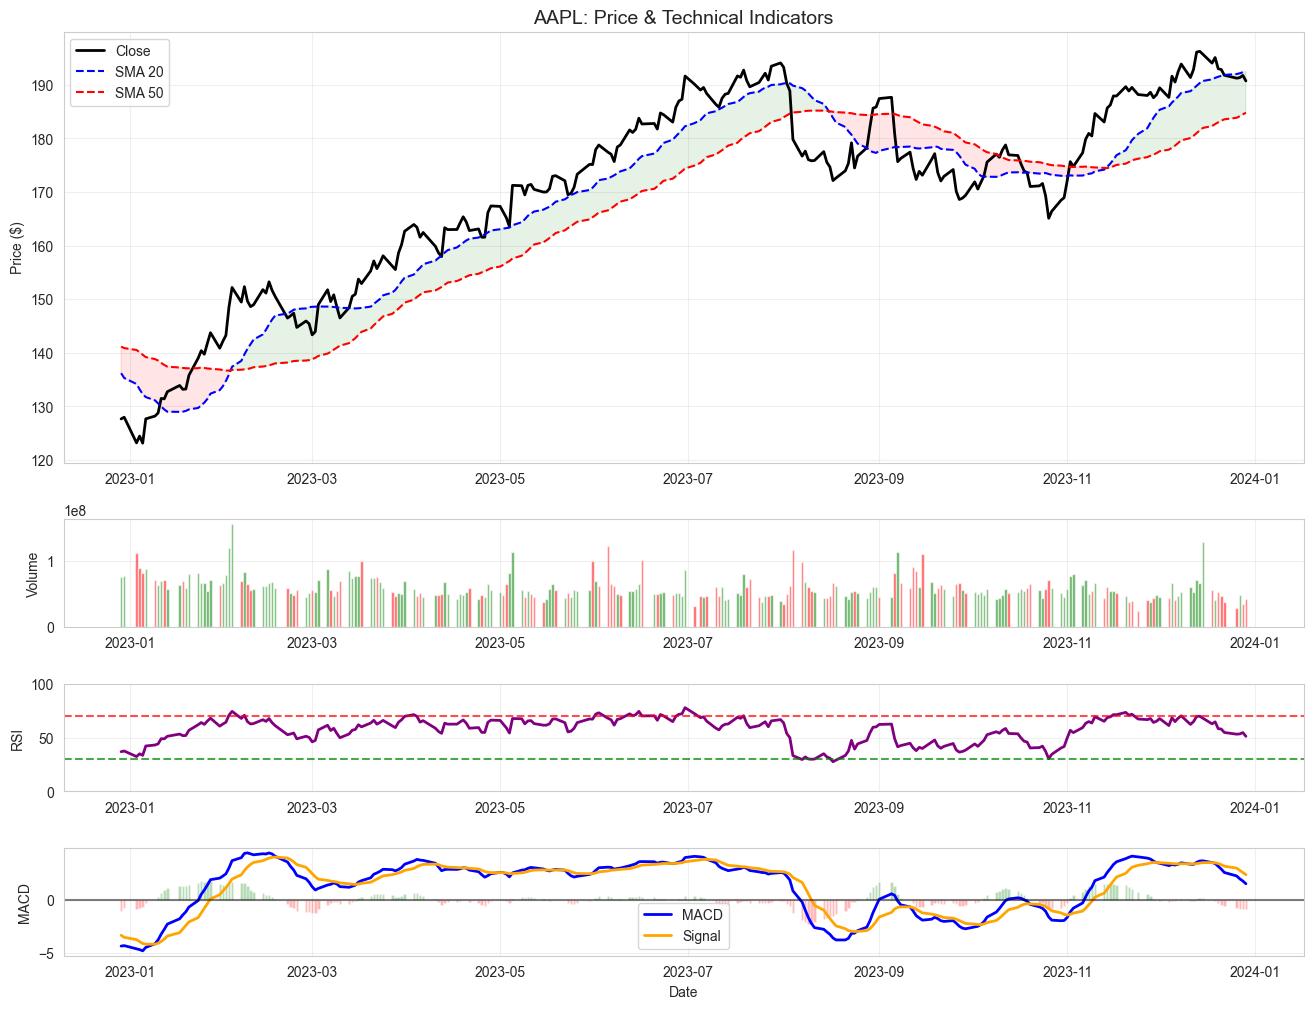

✅ Plotted AAPL | 0 buys, 0 sells


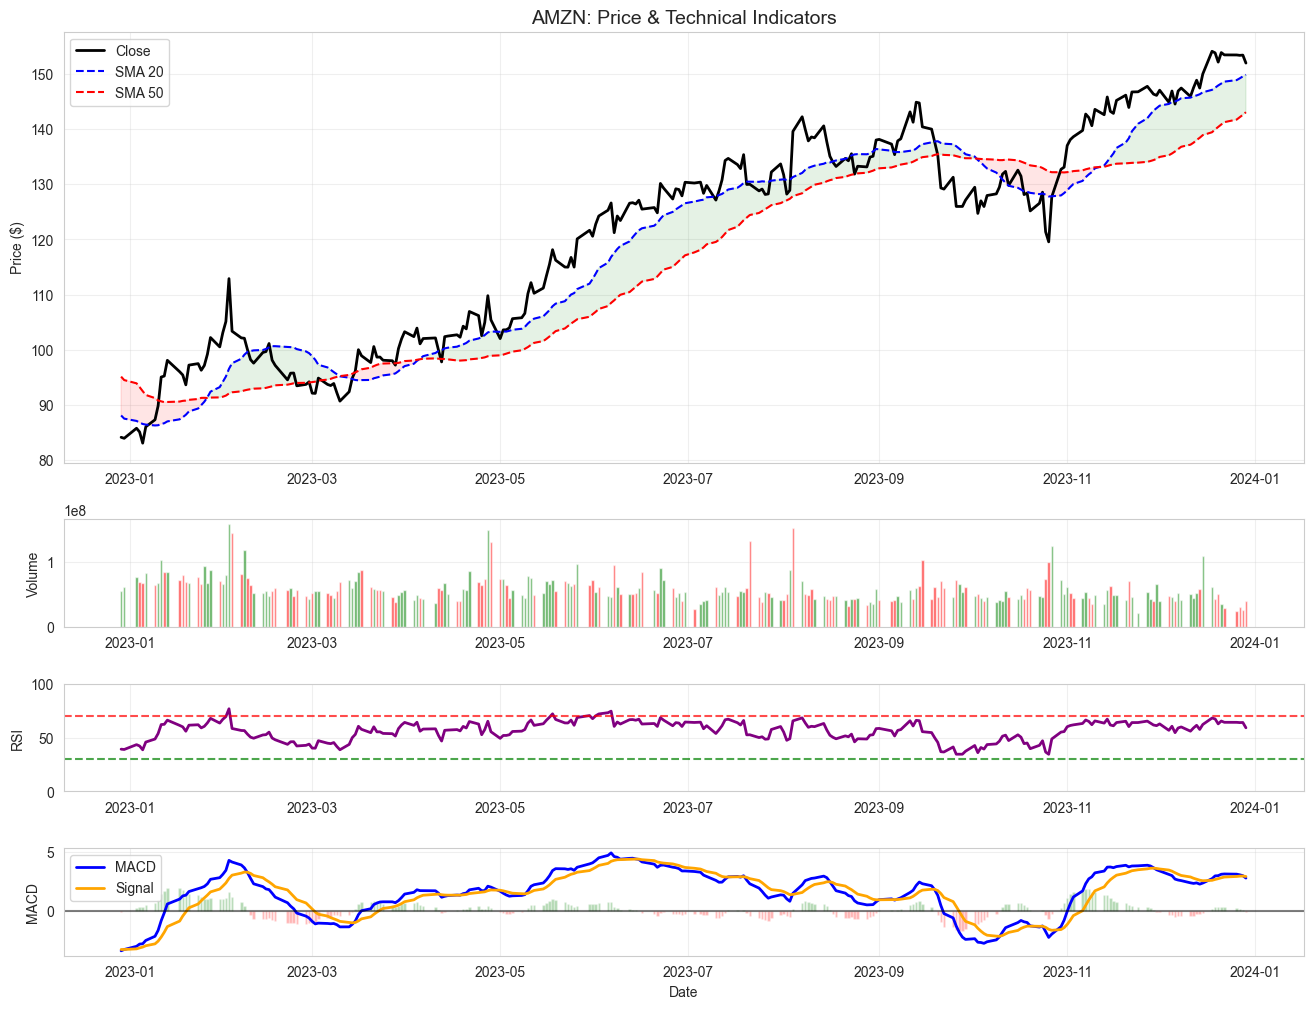

✅ Plotted AMZN | 0 buys, 0 sells


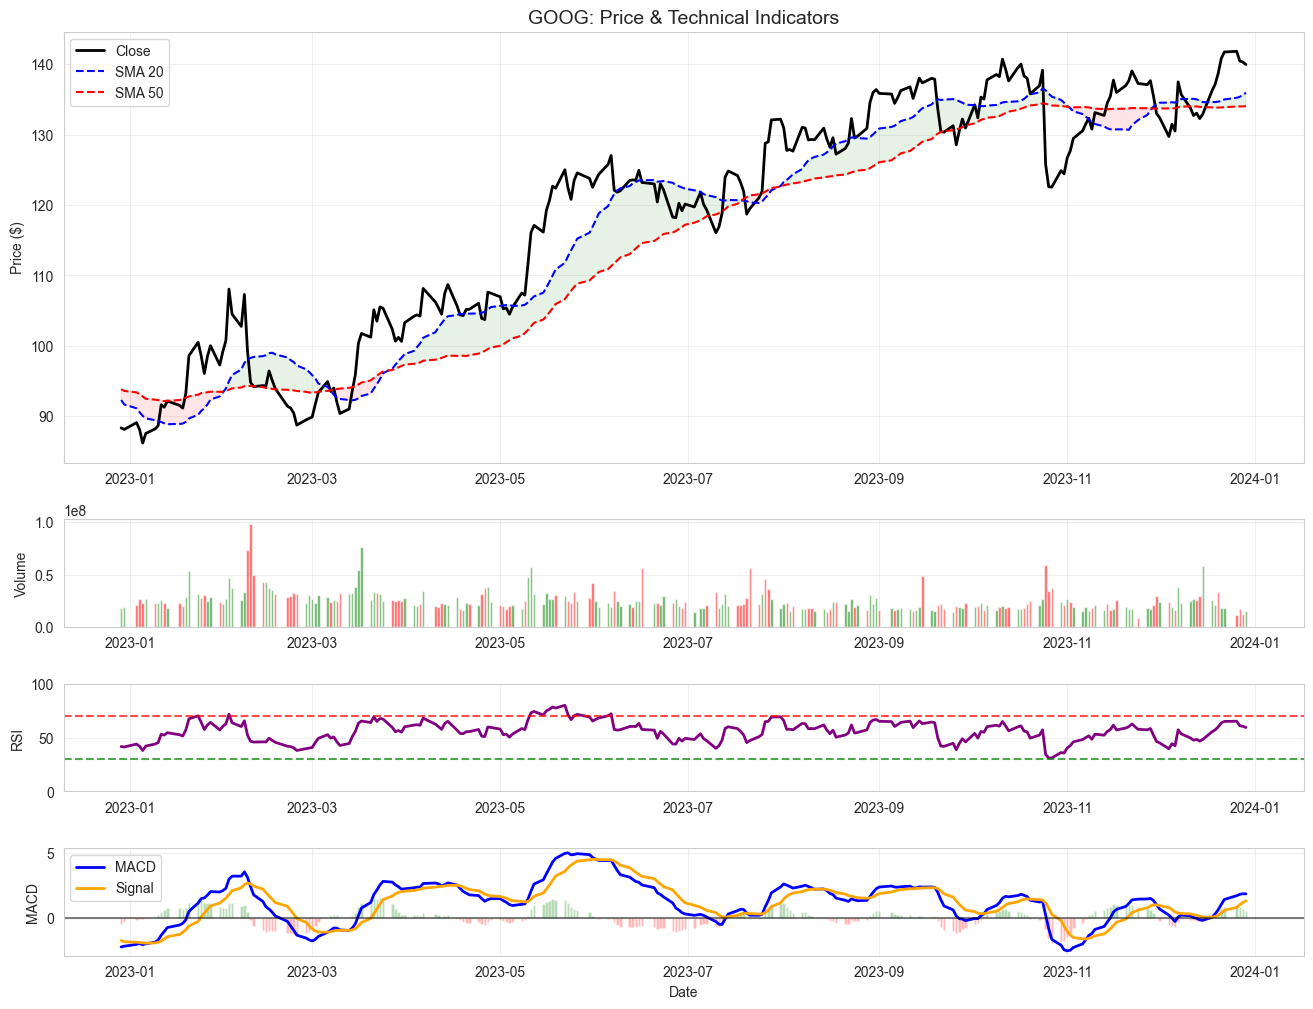

✅ Plotted GOOG | 0 buys, 0 sells


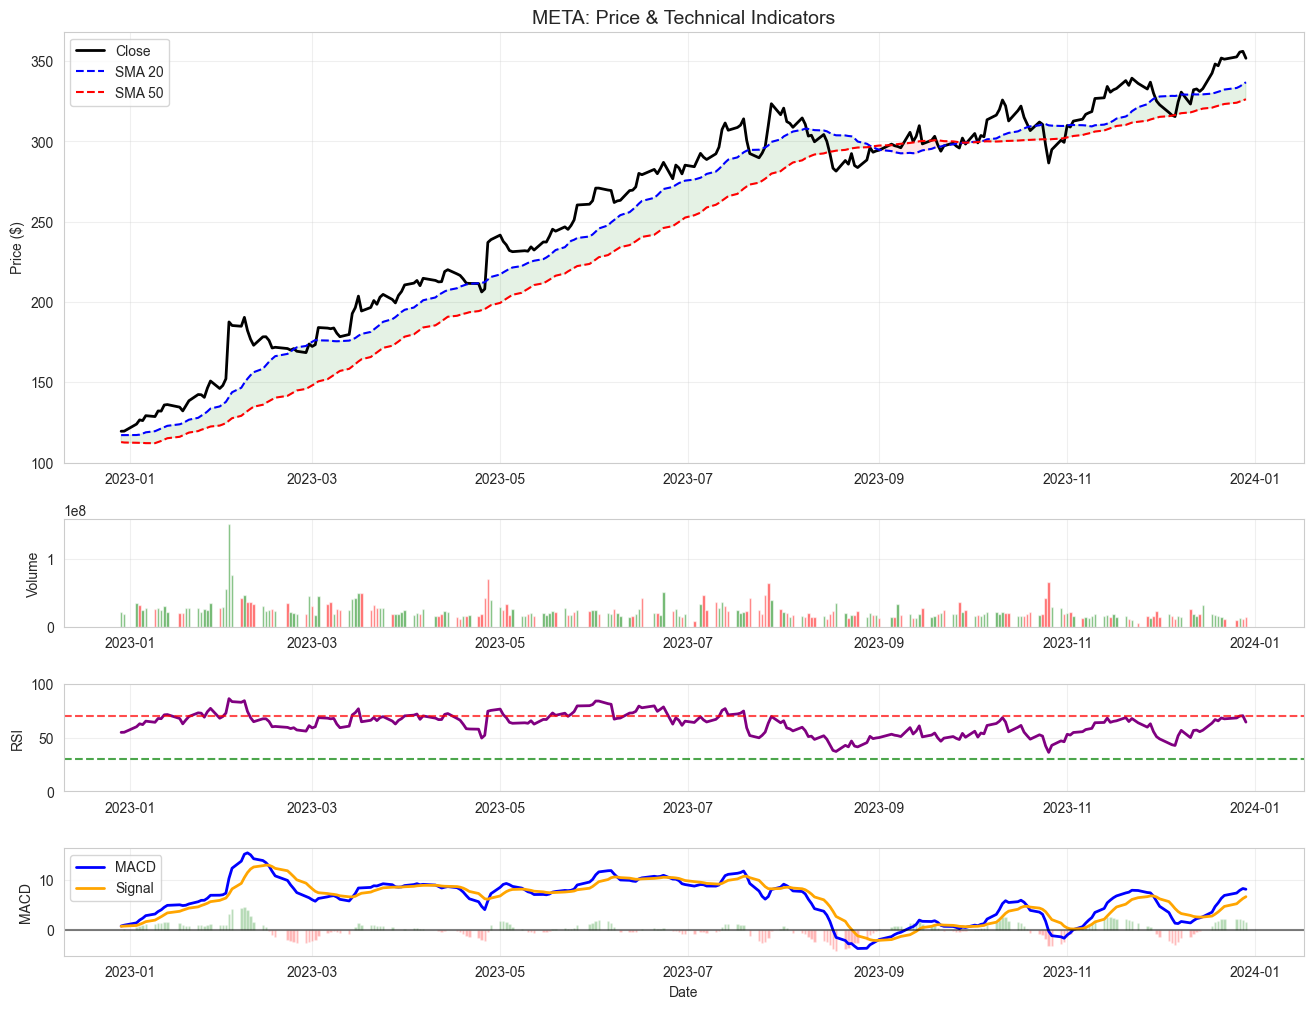

✅ Plotted META | 0 buys, 0 sells


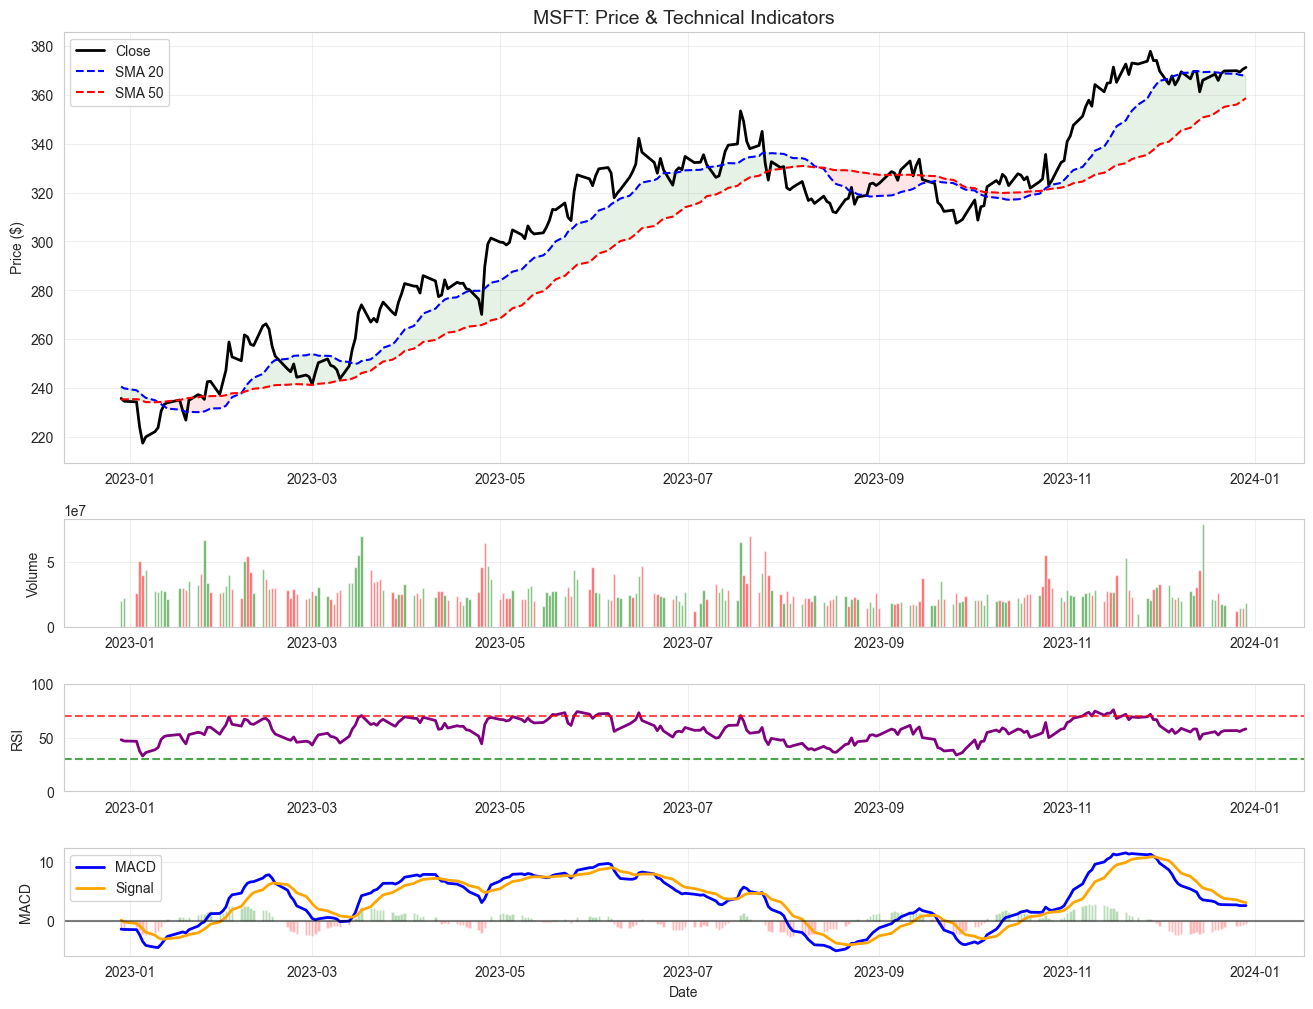

✅ Plotted MSFT | 0 buys, 0 sells


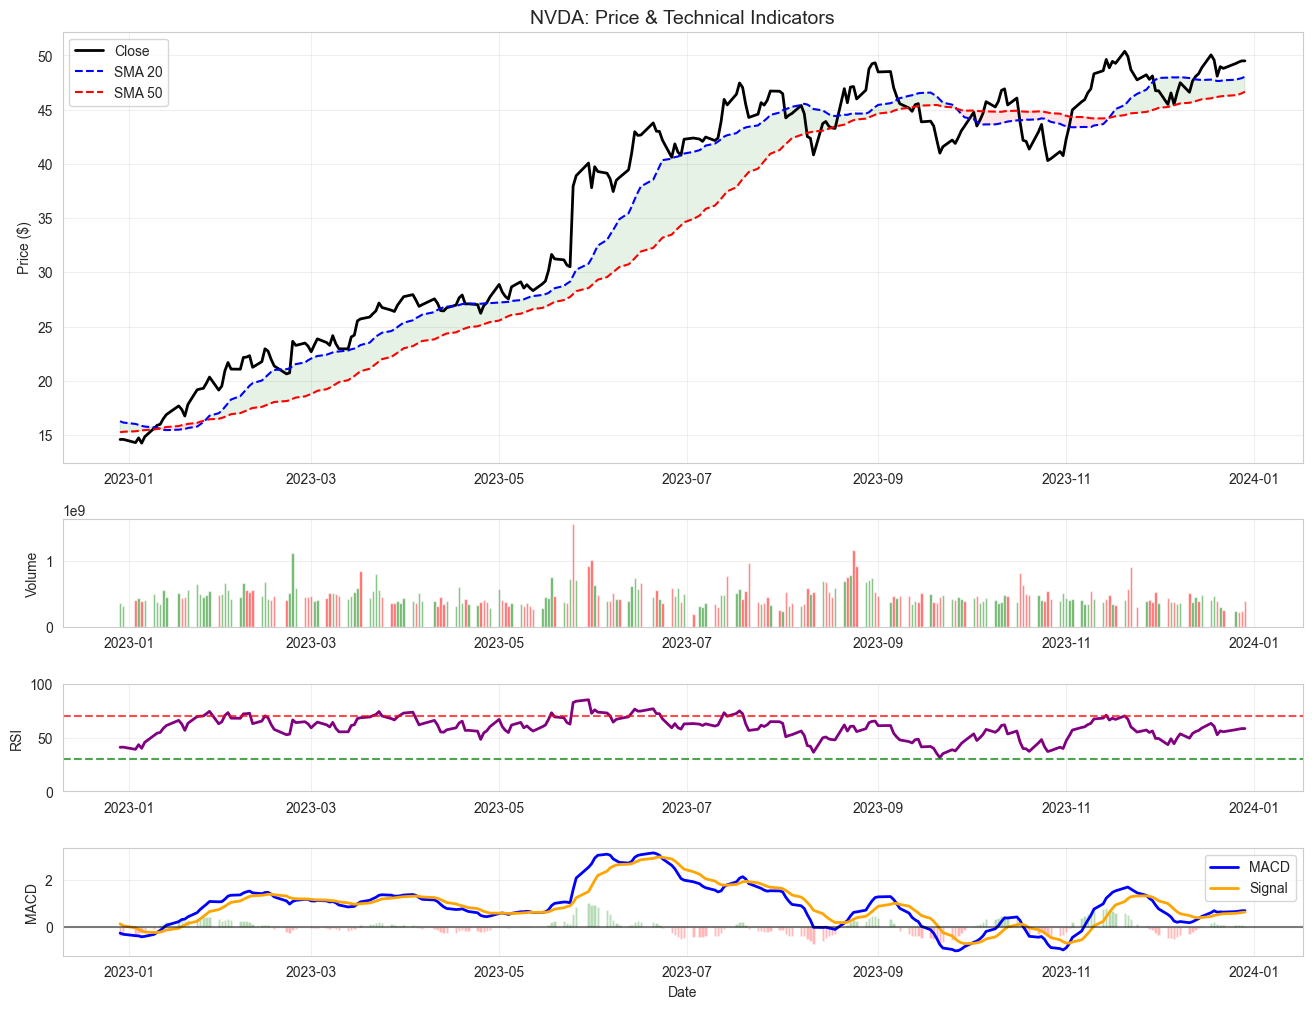

✅ Plotted NVDA | 0 buys, 0 sells


In [16]:
# =============================================================================
# VISUALIZATION
# =============================================================================
os.makedirs('plots', exist_ok=True)

def plot_indicators(df, ticker):
    dp = df.dropna(subset=['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD']).tail(252)
    if len(dp) < 50:
        print(f"   Skip plot for {ticker} (insufficient clean data)")
        return
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], hspace=0.3)
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(dp['Date'], dp['Close'], lw=2, label='Close', color='black')
    ax1.plot(dp['Date'], dp['SMA_20'], '--', label='SMA 20', color='blue')
    ax1.plot(dp['Date'], dp['SMA_50'], '--', label='SMA 50', color='red')
    ax1.fill_between(dp['Date'], dp['SMA_20'], dp['SMA_50'],
                     where=dp['SMA_20'] >= dp['SMA_50'], color='green', alpha=0.1)
    ax1.fill_between(dp['Date'], dp['SMA_20'], dp['SMA_50'],
                     where=dp['SMA_20'] < dp['SMA_50'], color='red', alpha=0.1)
    ax1.set_title(f'{ticker}: Price & Technical Indicators', fontsize=14)
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    buys = dp[dp['Signal'] == 1]
    sells = dp[dp['Signal'] == -1]
    ax1.scatter(buys['Date'], buys['Close'], marker='^', color='green', s=100, zorder=5)
    ax1.scatter(sells['Date'], sells['Close'], marker='v', color='red', s=100, zorder=5)
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    colors = ['green' if c >= o else 'red' for c, o in zip(dp['Close'], dp['Open'])]
    ax2.bar(dp['Date'], dp['Volume'], color=colors, alpha=0.6)
    ax2.set_ylabel('Volume')
    ax2.grid(alpha=0.3)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(dp['Date'], dp['RSI'], color='purple', lw=2)
    ax3.axhline(70, color='red', ls='--', alpha=0.7)
    ax3.axhline(30, color='green', ls='--', alpha=0.7)
    ax3.set_ylabel('RSI')
    ax3.set_ylim(0, 100)
    ax3.grid(alpha=0.3)
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax4.plot(dp['Date'], dp['MACD'], label='MACD', lw=2, color='blue')
    ax4.plot(dp['Date'], dp['MACD_Signal'], label='Signal', lw=2, color='orange')
    hist_colors = ['green' if h >= 0 else 'red' for h in dp['MACD_Hist']]
    ax4.bar(dp['Date'], dp['MACD_Hist'], color=hist_colors, alpha=0.3)
    ax4.axhline(0, color='black', alpha=0.5)
    ax4.set_ylabel('MACD')
    ax4.set_xlabel('Date')
    ax4.legend()
    ax4.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/{ticker}_indicators.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Plotted {ticker} | {len(buys)} buys, {len(sells)} sells")

for t in TICKERS:
    if t in stock_data:
        plot_indicators(stock_data[t], t)

In [17]:
# =============================================================================
# BACKTEST + PyNance METRICS
# =============================================================================
def backtest(df, cap0=INITIAL_CAPITAL):
    df = df.dropna(subset=['Signal', 'Close']).copy()
    cap = cap0
    pos = 0
    trades = []
    equity = [cap0]
    for _, r in df.iterrows():
        s, p, d = r['Signal'], r['Close'], r['Date']
        if s == 1 and pos == 0:
            shares = int(cap // p)
            if shares > 0:
                pos = shares
                cap -= shares * p
                trades.append({'Date': d, 'Type': 'BUY', 'Price': p, 'Shares': shares})
        elif s == -1 and pos > 0:
            cap += pos * p
            trades.append({'Date': d, 'Type': 'SELL', 'Price': p, 'Shares': pos})
            pos = 0
        equity.append(cap + (pos * p if pos > 0 else 0))
    if pos > 0:
        final_price = df['Close'].iloc[-1]
        cap += pos * final_price
        trades.append({'Date': df['Date'].iloc[-1], 'Type': 'SELL', 'Price': final_price, 'Shares': pos})
    total_return = (cap - cap0) / cap0 * 100
    bh_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100
    alpha = total_return - bh_return
    return cap, total_return, trades, bh_return, alpha, equity[1:], df['Date'].tolist()

results = []
pynance_results = []

for t in TICKERS:
    if t in stock_data:
        final_cap, strat_ret, trades, bh_ret, alpha, equity_curve, dates = backtest(stock_data[t])
        results.append({
            'Ticker': t,
            'Strat %': round(strat_ret, 2),
            'B&H %': round(bh_ret, 2),
            'Alpha %': round(alpha, 2),
            'Final Cap $': round(final_cap, 2),
            'Trades': len(trades)
        })

        # Build returns series for PyNance
        strat_returns = pd.Series(equity_curve).pct_change().dropna()
        bh_returns = stock_data[t].copy()
        bh_returns['Return'] = bh_returns['Close'].pct_change()
        bh_ret_series = bh_returns['Return'].dropna()
        metrics = compute_metrics_manual(strat_returns, bh_ret_series)
        metrics['Ticker'] = t
        pynance_results.append(metrics)


if results:
    print("\n" + "=" * 80)
    print("📊 BACKTEST RESULTS")
    print("=" * 80)
    res_df = pd.DataFrame(results)
    print(res_df.to_string(index=False))

if pynance_results:
    print("\n" + "=" * 80)
    print("📈 PyNANCE PERFORMANCE METRICS")
    print("=" * 80)
    pyn_df = pd.DataFrame(pynance_results)
    print(pyn_df.to_string(index=False))



📊 BACKTEST RESULTS
Ticker  Strat %    B&H %   Alpha %  Final Cap $  Trades
  AAPL   500.04  6907.74  -6407.71     60003.75       2
  AMZN   302.61  5490.14  -5187.53     40261.39       4
  GOOG   192.25  1660.96  -1468.72     29224.66       6
  META   173.34   825.87   -652.53     27333.85       2
  MSFT   269.01  2395.86  -2126.85     36901.06       6
  NVDA   301.66 24691.75 -24390.10     40165.66       6

📈 PyNANCE PERFORMANCE METRICS
 Ann. Return %  Ann. Volatility %  Sharpe Ratio  Max Drawdown %  Alpha    Beta Ticker
          6.17               9.13          0.68          -18.92 0.0629  0.0036   AAPL
          4.76              10.90          0.44          -16.76 0.0440  0.0272   AMZN
          3.65               7.67          0.48          -30.42 0.0376  0.0057   GOOG
          4.43              15.33          0.29          -46.41 0.0549 -0.0009   META
          4.46               7.17          0.62          -22.40 0.0448  0.0061   MSFT
          4.75              11.71        


🔤 TASK 3: SENTIMENT & STOCK RETURN CORRELATION
   ➤ GOOG: News rows = 10, Merged rows = 10


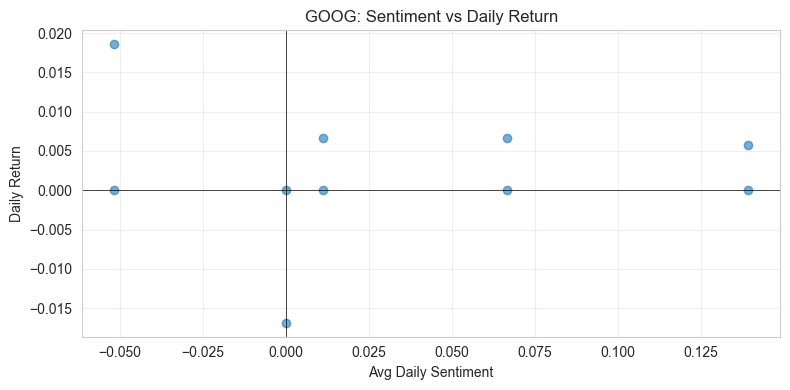

   ➤ NVDA: News rows = 10, Merged rows = 8


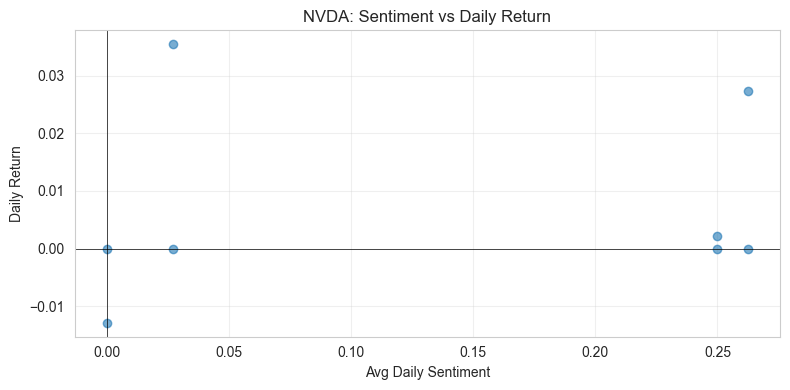


📈 Correlation Summary:
Ticker  Correlation  Days
  GOOG       -0.061    10
  NVDA        0.112     8

✅ ANALYSIS COMPLETE.


In [18]:
# =============================================================================
# SENTIMENT ↔ RETURN CORRELATION
# =============================================================================
print("\n" + "=" * 80)
print("🔤 TASK 3: SENTIMENT & STOCK RETURN CORRELATION")
print("=" * 80)
correlations = []
if df_news is not None:
    if 'stock' not in df_news.columns:
        print("⚠️ 'stock' column missing in news data → skipping Task 3.")
    else:
        for ticker in TICKERS:
            if ticker not in stock_data:
                continue
            news_ticker = df_news[df_news['stock'] == ticker].copy()
            if news_ticker.empty:
                continue
            stock_df = stock_data[ticker].copy()
            stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
            stock_df = stock_df.sort_values('Date')
            stock_df['Return'] = stock_df['Close'].pct_change()
            daily_sent = news_ticker.groupby('date_only')['sentiment'].mean().reset_index()
            daily_sent.rename(columns={'date_only': 'Date'}, inplace=True)
            merged = pd.merge(stock_df[['Date', 'Return']], daily_sent, on='Date', how='inner')
            if len(merged) < 5:
                continue
            print(f"   ➤ {ticker}: News rows = {len(news_ticker)}, Merged rows = {len(merged)}")
            corr = merged['Return'].corr(merged['sentiment'])
            correlations.append({
                'Ticker': ticker,
                'Correlation': round(corr, 3),
                'Days': len(merged)
            })
            plt.figure(figsize=(8, 4))
            plt.scatter(merged['sentiment'], merged['Return'], alpha=0.6)
            plt.title(f'{ticker}: Sentiment vs Daily Return')
            plt.xlabel('Avg Daily Sentiment')
            plt.ylabel('Daily Return')
            plt.axhline(0, color='k', lw=0.5)
            plt.axvline(0, color='k', lw=0.5)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'plots/{ticker}_sentiment_corr.png', dpi=200, bbox_inches='tight')
            plt.show()
        if correlations:
            corr_df = pd.DataFrame(correlations)
            print("\n📈 Correlation Summary:")
            print(corr_df.to_string(index=False))
        else:
            print("   ❌ No valid correlations.")
else:
    print("   ❌ No news data → skipping Task 3.")

print("\n✅ ANALYSIS COMPLETE.")